In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pypalettes import load_cmap
from highlight_text import fig_text

## Load Dataset

Load and aggregate data into number of casualties by **country**, broken down by **casualty severity**.


In [8]:
url = "https://raw.githubusercontent.com/anw-g01/dataviz-anw/refs/heads/main/road_safety_open_data_2016/data/road_accidents.csv"

df = pd.read_csv(url, parse_dates=["date_time"], date_format="%Y-%m-%d %H:%M:%S")

# create a frequency table by grouping the type of casualty severity for each country
freq = (
    df.groupby(["country", "casualty_severity"])
    .size()
    .reset_index(name="num_casualties")
    .sort_values(
        by="num_casualties",
        ascending=False
    )
)

# create a population table for each country
pop = (
    df.drop_duplicates(subset=["Area_Name"])    # filter for unique areas only to count total populations
    .groupby("country")["Population"]           # group by country and sum up all population counts
    .sum()
    .reset_index()                              # convert to a DataFrame for merging
)

df = pd.merge(
    left=freq,
    right=pop,
    how="left",
    on="country"
)

df["casualties_per_million"] = (df["num_casualties"] / df["Population"] * 1_000_000).round(2)

df

,country,casualty_severity,num_casualties,Population,casualties_per_million
0,England,slight,140746,55268067.0,2546.61
1,England,serious,21402,55268067.0,387.24
2,Scotland,slight,8998,5404700.0,1664.85
3,Wales,slight,5747,3113150.0,1846.04
4,Scotland,serious,1694,5404700.0,313.43
5,England,fatal,1498,55268067.0,27.10
6,Wales,serious,1005,3113150.0,322.82
7,Scotland,fatal,191,5404700.0,35.34
8,Wales,fatal,103,3113150.0,33.09


Pivot the grouped casualty counts so each severity level becomes a separate column for stacking.

In [9]:
# keep only casualties_per_million and pivot dataframe for compactness
df = df.pivot(
    index="country",
    columns="casualty_severity",
    values="casualties_per_million"
)

df["total"] = df.sum(axis=1)

df = df.round(1)

df

casualty_severity,fatal,serious,slight,total
country,,,,
England,27.1,387.2,2546.6,2961.0
Scotland,35.3,313.4,1664.8,2013.6
Wales,33.1,322.8,1846.0,2202.0


## Bar Chart - Number of Casualties by Country and Casualty Severity

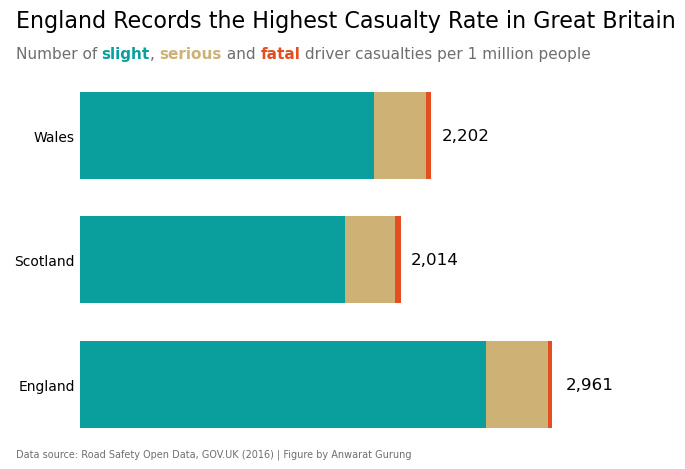

In [31]:
# choose a colour palette
cmap = load_cmap("AsteroidCity1")
colours = cmap.colors

# create a figure
fig, ax = plt.subplots()

# axes customisation
ax.spines[["top", "right", "bottom", "left"]].set_visible(False)
ax.tick_params(length=0)
ax.set_xticks([])

# create a stacked horizontal bar chart
stack_order = ["slight", "serious", "fatal"]
left = np.zeros(df.shape[0])    # array to stack bars horizontally
for severity, colour in zip(stack_order, colours):
    ax.barh(
        df.index,
        df[severity],
        left=left,
        height=0.7,
        color=colour
    )
    left += df[severity].values

# annotate totals to the right of each bar
for i, total in enumerate(df["total"]):
    ax.text(
        x=total * 1.03,
        y=i,
        s=f"{total:,.0f}",
        ha="left",
        va="center",
        fontsize=12,
        color="black"
    )

# chart title
x_value, y_value = 0.025, 0.98    # starting location of title text in figure coordinates
fig.text(
    x=x_value, y=y_value,
    s = "England Records the Highest Casualty Rate in Great Britain",
    fontsize=16,
)

# chart subtitle
fig_text(
    x=x_value, y=y_value * 0.96,
    s="Number of <slight>, <serious> and <fatal> driver casualties per 1 million people",
    highlight_textprops=[
        {"color": colours[0], "weight": "bold"},
        {"color": colours[1], "weight": "bold"},
        {"color": colours[2], "weight": "bold"},
    ],
    fontsize=11,
    color="#6e6e6e"
)

# chart caption
fig.text(
    x_value, 0.08,
    "Data source: Road Safety Open Data, GOV.UK (2016) | Figure by Anwarat Gurung",
    ha="left",
    va="bottom",
    fontsize=7,
    color="#6e6e6e",
)

# save figure as an image file
plt.savefig(r"..\images\casualty_severity_by_country.png", dpi=200, bbox_inches="tight")

plt.show()